In [1]:
import numpy as np
import cv2
import pandas as pd
import json
import os
import numpy as np
import torch
from PIL import Image


In [2]:
class Config(object):
    DATA_PATH = 'D:/Projects/Kaggle/iMaterialist-Fashion-2020-at-FGVC7/data/imaterialist-fashion-2020-fgvc7'
    IMAGE_SIZE = 256
    NO_OF_CLASSES = 46
    BATCH_SIZE = 3
    OUTPUT_MASK_SIZE=256
    RESIZE=True
    SHUFFLE=True
    STEP_SIZE=3
    CHECK_POINT_STEPS = 200


In [3]:
class iMetDataset(torch.utils.data.Dataset):
    def __init__(self, config, df, random_seed=0):       # transforms,
        self.CONFIG = config
        self.TRAINING_DATA_PATH = self.CONFIG.DATA_PATH + '/train/'
        self.TRAINING_DATA_FRAME = df
        self.imgs = self.TRAINING_DATA_FRAME.ImageId.unique()
        np.random.seed(random_seed)

    def make_single_mask(self, encoded_string, height, width):
        splitted_string = np.array(list(map(int, encoded_string.split()))).reshape(-1,2)
        mask = np.zeros((height*width), dtype=np.uint8)
        for start_indice, run_length in splitted_string:
            start_indice-=1
            mask[start_indice:start_indice+run_length] = 1
        return mask.reshape((height, width), order='F')

    def get_box(self, mask):
        w = np.sum(mask, axis=0)
        h = np.sum(mask, axis=1)
        x1, x2 = 0, len(w)-1
        y1, y2 = 0, len(h)-1
        while w[x1]==0:
            x1+=1
        while w[x2]==0:
            x2-=1
        while h[y1]==0:
            y1+=1
        while h[y2]==0:
            y2-=1
        return np.array([x1, y1, x2, y2], dtype=np.float32)

    def get_ground_truth(self, image_id):
        query = self.TRAINING_DATA_FRAME[self.TRAINING_DATA_FRAME.ImageId==image_id]
        encoded_pixels = query.EncodedPixels
        class_ids = query.ClassId
        height, width = list(query.Height)[0], list(query.Width)[0]

        masks=[]
        labels=[]
        boxes=[]

        for _, (encoded_pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
            sub_mask = self.make_single_mask(encoded_pixel_str, height, width)
            masks.append(sub_mask)
            boxes.append(self.get_box(sub_mask))
            labels.append(class_id)
            
        return {'boxes':np.array(boxes, dtype=np.float32),
                'labels':np.array(labels, dtype=np.int64),
                'masks':np.array(masks, dtype=np.uint8)}


    def __getitem__(self, idx):
        img_path = self.TRAINING_DATA_PATH + self.imgs[idx] + '.jpg'
        img = np.array(cv2.cvtColor( cv2.imread(img_path), cv2.COLOR_BGR2RGB)/255, dtype=np.float32)
        img = np.moveaxis(img, -1, 0)
        target = self.get_ground_truth(self.imgs[idx])
        #print(img.shape, self.imgs[idx], idx)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    print(in_features)
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    print('input fo mask classifier', in_features_mask)
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)

    return model

In [6]:
def dfs_freeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)

# Main

In [7]:
conf = Config()
train_df = pd.read_csv(conf.DATA_PATH+'/train.csv')

In [8]:
from torch.utils import data
from tqdm.notebook import tqdm_notebook
import math
import torchvision
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


In [9]:
d = iMetDataset(conf, train_df)
torch.random.manual_seed(5)
iMetDataloader = data.DataLoader(d, batch_size=conf.BATCH_SIZE, shuffle=conf.SHUFFLE, collate_fn=collate_fn)

In [10]:
saved_model = 'iMetModel_epoch_0_step_2700_loss_1.1637932062149048.model'
__step = int(saved_model.split('_')[4])+1
EPOCH = int(saved_model.split('_')[2])

#iMetModel = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=conf.NO_OF_CLASSES, pretrained_backbone=True)
if saved_model != '':
    iMetModel = torch.load('model/'+saved_model)
else:
    iMetModel = get_model_instance_segmentation(conf.NO_OF_CLASSES)
    
_ = iMetModel.to(device)

for n,c in iMetModel.named_children():
    if n==str('rpn') or n==str('roi_heads'):
        print('freezing:', n)
        for param in c.parameters():
            param.requires_grad = False
            dfs_freeze(c)

params = [p for p in iMetModel.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

freezing: rpn
freezing: roi_heads


In [11]:
iMetModel.train()

for images, targets in tqdm_notebook(iMetDataloader):

    images = [torch.tensor(image, dtype = torch.float32).to(device) for image in images]
    targets = [{k: torch.tensor(v).to(device) for k, v in target.items()} for target in targets]
    
    loss_dictionary = iMetModel(images,targets)
    summed_loss = sum(loss for loss in loss_dictionary.values())
    summed_loss_value = summed_loss.item()
    
    
    if __step%conf.STEP_SIZE==0:
        loss_str=''
        for loss_type, value in loss_dictionary.items():
            loss_str+=str(loss_type)+': '+str(round(value.item(),6))+'   '
        print(loss_str)
        print('step: ',__step ,'    Total Loss: ', summed_loss_value )
        
        
    
    if math.isfinite(summed_loss_value):
        optimizer.zero_grad()
        summed_loss.backward()
        optimizer.step()
        
    else:
        print('Loss is undefined:',summed_loss_value,'   skipping BackProp for step no:', __step)
        print(loss_dictionary)
        
        
    
    if __step%conf.CHECK_POINT_STEPS==0:
        print('')
        print('====================================================================================================')
        print('')
        torch.save(iMetModel, 'model/iMetModel_epoch_'+str(EPOCH)+'_step_'+str(__step)+'_loss_'+str(summed_loss_value)+'.model')
        print('model saved at step:', __step)
        torch.cuda.empty_cache()
        print('cuda cache cleared')
        print('')
        print('====================================================================================================')
        print('')
        
        
        
    
        
    __step+=1



C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


loss_classifier: 0.244209   loss_box_reg: 0.137661   loss_mask: 0.291388   loss_objectness: 0.011261   loss_rpn_box_reg: 0.071187   
step:  2703     Total Loss:  0.7557061910629272
loss_classifier: 0.163963   loss_box_reg: 0.054938   loss_mask: 0.195654   loss_objectness: 0.013457   loss_rpn_box_reg: 0.06301   
step:  2706     Total Loss:  0.4910224378108978
loss_classifier: 0.153109   loss_box_reg: 0.05999   loss_mask: 0.16153   loss_objectness: 0.005784   loss_rpn_box_reg: 0.02299   
step:  2709     Total Loss:  0.40340232849121094
loss_classifier: 0.292602   loss_box_reg: 0.094986   loss_mask: 0.171624   loss_objectness: 0.024997   loss_rpn_box_reg: 0.14609   
step:  2712     Total Loss:  0.7302983403205872
loss_classifier: 0.129501   loss_box_reg: 0.087027   loss_mask: 0.188917   loss_objectness: 0.006817   loss_rpn_box_reg: 0.066209   
step:  2715     Total Loss:  0.4784712791442871
loss_classifier: 0.26875   loss_box_reg: 0.078114   loss_mask: 0.195372   loss_objectness: 0.009868

loss_classifier: 0.197676   loss_box_reg: 0.054125   loss_mask: 0.143171   loss_objectness: 0.00312   loss_rpn_box_reg: 0.04126   
step:  2835     Total Loss:  0.43935179710388184
loss_classifier: 0.129708   loss_box_reg: 0.061554   loss_mask: 0.134468   loss_objectness: 0.00233   loss_rpn_box_reg: 0.022003   
step:  2838     Total Loss:  0.35006314516067505
loss_classifier: 0.272534   loss_box_reg: 0.101324   loss_mask: 0.24104   loss_objectness: 0.01006   loss_rpn_box_reg: 0.198505   
step:  2841     Total Loss:  0.8234623670578003
loss_classifier: 0.10258   loss_box_reg: 0.060556   loss_mask: 0.160106   loss_objectness: 0.003015   loss_rpn_box_reg: 0.129423   
step:  2844     Total Loss:  0.455679714679718
loss_classifier: 0.237743   loss_box_reg: 0.121094   loss_mask: 0.198257   loss_objectness: 0.0058   loss_rpn_box_reg: 0.23061   
step:  2847     Total Loss:  0.7935032844543457
loss_classifier: 0.179532   loss_box_reg: 0.096837   loss_mask: 0.222531   loss_objectness: 0.011888   

RuntimeError: CUDA out of memory. Tried to allocate 2.83 GiB (GPU 1; 12.00 GiB total capacity; 5.66 GiB already allocated; 2.68 GiB free; 6.86 GiB reserved in total by PyTorch)

transform True
backbone False
rpn False
freezing: rpn
roi_heads False
freezing: roi_heads


In [ ]:
iMetModel

# Eval

In [10]:
M__ = torch.load('model/iMetModel_epoch_0_step_3000_loss_1.1532824039459229.model')

In [11]:
M__.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequentia

In [66]:
a,b = d[1]

In [67]:
device = torch.device('cpu')

In [68]:
b['boxes'] = torch.tensor(b['boxes'], dtype = torch.float32)
b['labels'] = torch.tensor(b['labels'], dtype=torch.int64)
b['masks'] = torch.tensor(b['masks'], dtype=torch.uint8)
a = torch.tensor(a, dtype=torch.float32).to(device)

In [69]:
M__.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequentia

In [70]:
r = M__([a])

In [71]:
b['labels']

tensor([33,  1])

In [72]:
r

[{'boxes': tensor([[ 888.7122,  387.5417, 1523.1628,  662.2922],
          [ 500.5925,  336.3864, 1826.4224, 2289.2073],
          [ 506.6111,  299.9686, 2073.4028, 2213.1248],
          [ 902.9332,  374.8637, 1489.8585,  537.7057],
          [1755.7552,  988.3752, 1905.9825, 2067.6350],
          [ 566.0560,  382.9998, 1766.4264, 2231.0781],
          [ 586.8345,  512.6924,  720.2310,  653.4162],
          [ 601.2071,  495.6941,  768.7727,  691.5023],
          [1657.0020,  550.8086, 1932.9948, 2167.5281]], grad_fn=<StackBackward>),
  'labels': tensor([33, 10,  1, 33, 31,  8, 31, 31, 31]),
  'scores': tensor([0.9989, 0.6159, 0.5684, 0.2277, 0.1456, 0.0697, 0.0694, 0.0640, 0.0585],
         grad_fn=<IndexBackward>),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..

In [50]:
b_masks = r[0]['masks'].detach().numpy()
img = a.detach().numpy()
img = np.moveaxis(img, 0,-1)

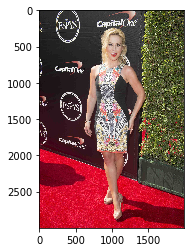

In [51]:
import matplotlib.pyplot as plt
plt.imshow(img)

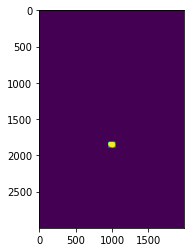

In [65]:
import matplotlib.pyplot as plt
plt.imshow(b_masks[5][0])

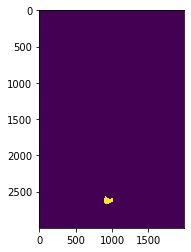

In [62]:
plt.imshow(b['masks'][3])

In [100]:


import torch
import torchvision
import torch.nn as nn
import copy


import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [7]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    print(in_features)
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    print('input fo mask classifier', in_features_mask)
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)

    return model



In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

conf = config.Config()
train_df = pd.read_csv(conf.DATA_PATH+'/train.csv')
print('Loaded train_df!')
print(train_df.head())

Loaded train_df!
                            ImageId  \
0  00000663ed1ff0c4e0132b9b9ac53f6e   
1  00000663ed1ff0c4e0132b9b9ac53f6e   
2  00000663ed1ff0c4e0132b9b9ac53f6e   
3  00000663ed1ff0c4e0132b9b9ac53f6e   
4  00000663ed1ff0c4e0132b9b9ac53f6e   

                                       EncodedPixels  Height  Width  ClassId  \
0  6068157 7 6073371 20 6078584 34 6083797 48 608...    5214   3676        6   
1  6323163 11 6328356 32 6333549 53 6338742 75 63...    5214   3676        0   
2  8521389 10 8526585 30 8531789 42 8537002 46 85...    5214   3676       28   
3  12903854 2 12909064 7 12914275 10 12919485 15 ...    5214   3676       31   
4  10837337 5 10842542 14 10847746 24 10852951 33...    5214   3676       32   

                     AttributesIds  
0  115,136,143,154,230,295,316,317  
1  115,136,142,146,225,295,316,317  
2                              163  
3                          160,204  
4                              219  


In [12]:
torch.random.manual_seed(0)
d = iMetDataset(conf, train_df, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(d, batch_size=conf.BATCH_SIZE, shuffle=True, num_workers=2,collate_fn=utils.collate_fn)
print('Initialized data loader')

# get the model using our helper function
model = get_model_instance_segmentation(conf.NO_OF_CLASSES)
print('Loaded model!')
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3, gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10



Initialized data loader
1024
input fo mask classifier 256
Loaded model!


In [13]:
for epoch in range(num_epochs):
    print('Epoch '+str(epoch))
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    print("Evaluating at end of epoch")
    evaluate(model, data_loader_test, device=device)

print("That's it!")


Epoch 0


AttributeError: 'numpy.ndarray' object has no attribute 'to'